<a href="https://colab.research.google.com/github/AyaTareekAhmmeed/Deep-Neural-Network/blob/main/Word_Embeddings_example_using_IMDb_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A potential drawback with one-hot encoded feature vector approaches such as N-Grams, bag of words and TF-IDF approach is that the feature vector for each document can be huge.
For instance, if you have a half million unique words in your corpus and you want to represent a sentence that contains 10 words, your feature vector will be a half million dimensional one-hot encoded vector where only 10 indexes will have 1.
This is a wastage of space and increases algorithm complexity exponentially resulting in the curse of dimentionality.
In word embeddings, every word is represented as an n-dimensional dense vector. The words that are similar will have similar vector.
Word embeddings techniques such as GloVe and Word2Vec have proven to be extremely efficient for converting words into corresponding dense vectors. 
The vector size is small and none of the indexes in the vector is actually empty.
the Keras library contains a layer called Embedding(). 
The embedding layer is implemented in the form of a class in Keras and is normally used as a first layer in the sequential model for NLP tasks.


In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
from keras.preprocessing.text import one_hot
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

In [11]:
#Let's now import and analyze our dataset
movie_reviews =pd.read_csv("/content/IMDB Dataset.csv",engine='python', error_bad_lines=False) 


movie_reviews.isnull().values.any()
movie_reviews.shape

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


(50000, 2)

As a first step, we will use the Tokenizer class from the keras.preprocessing.text module to create a word-to-index dictionary. In the word-to-index dictionary, each word in the corpus is used as a key, while a corresponding unique index is used as the value for the key.

In [12]:
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


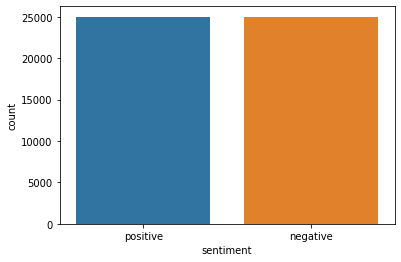

In [13]:
#plotting data
import seaborn as s

s.countplot(x='sentiment', data=movie_reviews)

From the output, it is clear that the dataset contains equal number of positive and negative reviews

In [14]:
#1st stage : Data Preprocessing and cleaning we nwwd to clean data to be able to make sentiment analysis on it this is done by removing all special characters from our  dataset
#we will define a function that takes a text string as a parameter and then performs preprocessing on the string to remove special characters 
def preprocess_text(sen):
  # Removing html tags
  sentence = remove_tags(sen)

  # Remove punctuations and numbers
  sentence = re.sub('[^a-zA-Z]', ' ', sentence)

  # Single character removal
  sentence = re.sub(r"\\s+[a-zA-Z]\\s+", ' ', sentence)

  # Removing multiple spaces to avoid hold incoding vector"word embedding"
  sentence = re.sub(r'\\s+', ' ', sentence)

  return sentence

In [15]:
#remove tags
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
  return TAG_RE.sub('', text)

In [16]:
review = []
sentences = list(movie_reviews['review'])

for sen in sentences:
   review.append(preprocess_text(sen))

print(review[4]) #we can see that all special characters are removed "it produces very clean text"

Petter Mattei s  Love in the Time of Money  is a visually stunning film to watch  Mr  Mattei offers us a vivid portrait about human relations  This is a movie that seems to be telling us what money  power and success do to people in the different situations we encounter  This being a variation on the Arthur Schnitzler s play about the same theme  the director transfers the action to the present time New York where all these different characters meet and connect  Each one is connected in one way  or another to the next person  but no one seems to know the previous point of contact  Stylishly  the film has a sophisticated luxurious look  We are taken to see how these people live and the world they live in their own habitat The only thing one gets out of all these souls in the picture is the different stages of loneliness each one inhabits  A big city is not exactly the best place in which human relations find sincere fulfillment  as one discerns is the case with most of the people we enc

Next Step convert our labels into integers. Since we only have two labels in the output i.e. "positive" and "negative". convert them into integers by replacing "positive" --> 1 and negative --> 0 as shown below:

In [17]:
converted = movie_reviews['sentiment'] #sentiment is our parameter that contain positive and negative 

converted = np.array(list(map(lambda x: 1 if x=="positive" else 0, converted))) #noe we are going to deal with reviews and converted 

we need to divide our dataset into train and test sets. The train set will be used to train our deep learning models and it contains of our reviews after cleaning and our converted data, while the test set will be used to evaluate how well our model performs.


In [18]:
review_train, review_test, converted_train, converted_test = train_test_split(review, converted, test_size=0.20, random_state=42)

let's now write the script for our embedding layer. The embedding layer converts our textual data into numeric data and is used as the first layer for the deep learning models in Keras.

In [19]:
#Tokenizer class from the keras.preprocessing.text module to create a word-to-index dictionary. In the word-to-index dictionary, each word in the corpus is used as a key, while a corresponding unique index is used as the value for the key.
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(review_train)

review_train = tokenizer.texts_to_sequences(review_train)
review_test = tokenizer.texts_to_sequences(review_test)

We set the maximum size of each list to 100. You can try a different size. The lists with size greater than 100 will be truncated to 100. For the lists that have length less than 100, we will add 0 at the end of the list until it reaches the max length. This process is called padding.

In [20]:
vocab_size = len(tokenizer.word_index) + 1 #+ 1 cuz our indexes start with 0

maxlen = 100

review_train = pad_sequences(review_train, padding='post', maxlen=maxlen)
review_test = pad_sequences(review_test, padding='post', maxlen=maxlen)

if you see review_train and review_test all the lists have same length i.e. 100. Also, the vocabulary_size variable now contains a value 92547 which means that our corpus has 92547 unique words.

In [24]:
#GloVe embeddings used for mapping each word with some vector cuz it contains keys for most English word
#we will use GloVe embeddings to create our feature matrix.GloVe embeddings gives weight for each unique word. In the following script we load the GloVe word embeddings and create a dictionary that will contain words as keys and their corresponding embedding list as values.
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open("/content/glove.6B.100d.txt", encoding="utf8")

for line in glove_file:
   records = line.split()
   word = records[0]
   vector_dimensions = asarray(records[1:], dtype='float32') #dtype='float32' cuz our data in range -1:1
   embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [25]:
#Finally, we will create an embedding matrix where each row number will correspond to the index of the word in the corpus. The matrix will have 100 columns where each column will contain the GloVe word embeddings for the words in our corpus.
embedding_matrix = zeros((vocab_size, 100)) #100 num of columns 
for word, index in tokenizer.word_index.items():
  embedding_vector = embeddings_dictionary.get(word)
  if embedding_vector is not None:
     embedding_matrix[index] = embedding_vector

In [26]:
#create model
from keras.layers import LSTM

model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)#100 our dimensions & ourb model is not trainable 
model.add(embedding_layer) #embedding is our first layer
model.add(LSTM(128)) #128 num of Dense neurons 

model.add(Dense(1, activation='sigmoid')) #1 neuron cuz it is whether positive or negative & activation='sigmoid' cuz it is last layer &
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9254700   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 9,372,077
Trainable params: 117,377
Non-trainable params: 9,254,700
_________________________________________________________________


Trainable params: 117,377 cuz we only train LSTM not Embedding layers.

we create a Sequential model and add the Embedding layer as the first layer to the model. The length of the vocabulary is specified by the vocab_length parameter. The dimension of each word vector will be 20 and the input_length will be the length of the longest sentence, which is 300. Next, the Embedding layer is flattened so that it can be directly used with the densely connected layer. Since it is a binary classification problem, we use the sigmoid function as the loss function at the dense layer.

In [7]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 1, 20)        1000      
                                                                 
 flatten (Flatten)           (None, 6000)              0         
                                                                 
 dense (Dense)               (None, 1)                 6001      
                                                                 
Total params: 7,001
Trainable params: 7,001
Non-trainable params: 0
_________________________________________________________________
None


In [27]:
history = model.fit(review_train, converted_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

score = model.evaluate(review_test, converted_test, verbose=1)

Epoch 1/10
250/250 [==============================] - 77s 300ms/step - loss: 0.5853 - acc: 0.6894 - val_loss: 0.5051 - val_acc: 0.7592
Epoch 2/10
250/250 [==============================] - 71s 285ms/step - loss: 0.4747 - acc: 0.7757 - val_loss: 0.4680 - val_acc: 0.7900
Epoch 3/10
250/250 [==============================] - 87s 347ms/step - loss: 0.4263 - acc: 0.8032 - val_loss: 0.4123 - val_acc: 0.8044
Epoch 4/10
250/250 [==============================] - 79s 314ms/step - loss: 0.3937 - acc: 0.8227 - val_loss: 0.3792 - val_acc: 0.8230
Epoch 5/10
250/250 [==============================] - 83s 331ms/step - loss: 0.3691 - acc: 0.8351 - val_loss: 0.3915 - val_acc: 0.8210
Epoch 6/10
250/250 [==============================] - 78s 313ms/step - loss: 0.3465 - acc: 0.8471 - val_loss: 0.3685 - val_acc: 0.8436
Epoch 7/10
250/250 [==============================] - 73s 293ms/step - loss: 0.3278 - acc: 0.8560 - val_loss: 0.3686 - val_acc: 0.8345
Epoch 8/10
250/250 [==============================] - 7

In [28]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.34930741786956787
Test Accuracy: 0.8511000275611877


In [33]:
#using some real random data from our dataset to test our model
instance = review[10]
print(instance)

Phil the Alien is one of those quirky films where the humour is based around the oddness of everything rather than actual punchlines At first it was very odd and pretty funny but as the movie progressed I didn t find the jokes or oddness funny anymore Its a low budget film  thats never a problem in itself   there were some pretty interesting characters  but eventually I just lost interest I imagine this film would appeal to a stoner who is currently partaking For something similar but better try  Brother from another planet 


To predict the sentiment of this review, we have to convert this review into numeric form. We can do so using the tokenizer that we created in word embedding section. The text_to_sequences method will convert the sentence into its numeric counter part.\n", "\n", "Next, we need to pad our input sequence as we did for our corpus. Finally, we can use the predict method of our model and pass it our processed input sequence.

In [34]:
instance = tokenizer.texts_to_sequences(instance)

flat_list = [] #var to save our operations in it
for sublist in instance:
   for item in sublist:
     flat_list.append(item)
     
flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

model.predict(instance)

1/1 [==============================] - 0s 24ms/step


array([[0.7333697]], dtype=float32)

Remember, we mapped the positive outputs to 1 and the negative outputs to 0. However, the sigmoid function predicts floating value between 0 and 1. If the value is less than 0.5, the sentiment is considered negative where as if the value is greater than 0.5, the sentiment is considered as positive.

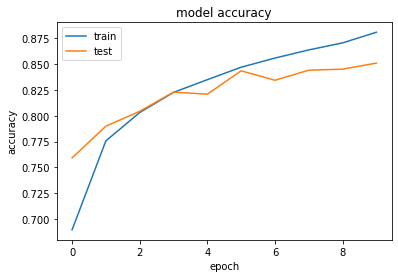

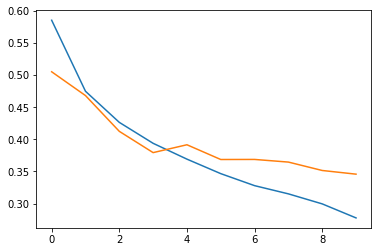

In [35]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [36]:
#saving model to reuse its weights
model.save("Word_Embeddings_modelh5.h5")
print('saved')

saved
